# Import Dependencies

In [1]:
import numpy as np 
import cv2 as cv
import matplotlib.pyplot as plt
from pygments.formatters import img

from utils.edge_extraction import *
from utils.feature_extraction import * 
from utils.fourier_transform import * 
from utils.image_conversion import * 
from utils.contrast_enhancement import *

# Noise Reduction 

In order to decrease the noise present in certain images (whole artworks and fragments), we intend to rely on the fourier transform and process the image in the frequency domain. 


#### Gray scale problem conversion 
To compute the DFT of an image, we need to either convert it to grayscale or ensure it has only one channel.


Converting an image from RGBA to grayscale can be convenient but comes at a cost — the loss of RGB color and alpha channel data. This can be troublesome if we later rely on that information for specific purposes.

Alternatively, we can split the image into its primary color channels and process each channel separately in the frequency domain, excluding the alpha channel. After filtering, we can reconstruct the new filtered image by recombining these processed channels.

To enhance the details to facilitate the extraction of features in subsequent steps we can apply contrast enhancing techniques. 


In [80]:
# read the image as png -> 4 channels (blue, green, red, alpha)
image = cv.imread('data/5.2.16.png', cv.IMREAD_UNCHANGED) 

# we need to preserve the information about the alpha channel (mainly for visualization and edge extraction purposes) 
b, g, r, a = cv.split(image)

# Contrast enhancing

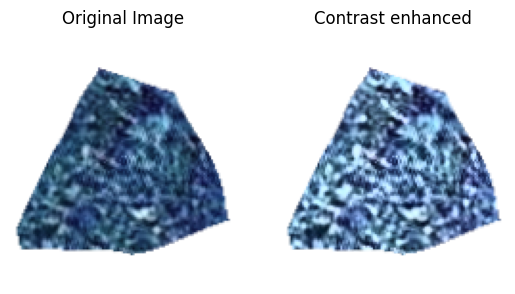

In [88]:
contrast_enhanced_image = enhance_contrast(image, a)

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(contrast_enhanced_image)
plt.title('Contrast enhanced')
plt.axis("off")
plt.show()

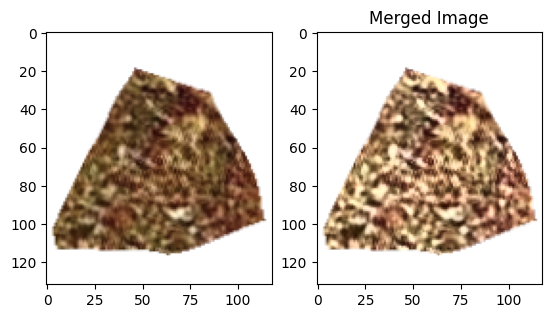

In [90]:
plt.subplot(1, 2, 1)
plt.imshow(cv.merge((cv.cvtColor(image, cv.COLOR_BGR2RGB), a)))
plt.subplot(1, 2, 2)
plt.imshow(cv.merge((cv.cvtColor(contrast_enhanced_image, cv.COLOR_BGR2RGB), a)))
plt.title('Merged Image')
plt.show()


# Upscaling

In [7]:
import tensorflow as tf
import tensorflow_hub as hub


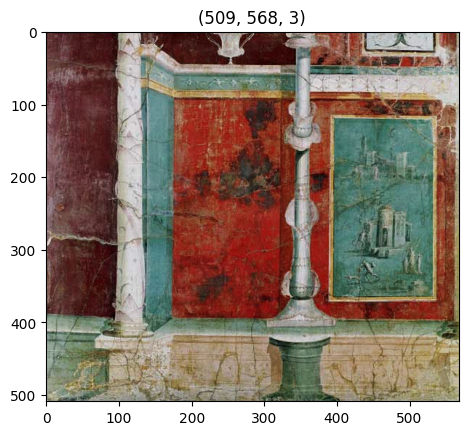

In [26]:
image_plot = cv.cvtColor(image, cv.COLOR_BGR2RGB)
plt.title(image_plot.shape)
plt.imshow(image_plot)
plt.show()

In [23]:
def preprocessing(img):
    imageSize = (tf.convert_to_tensor(image_plot.shape[:-1]) // 4) * 4
    cropped_image = tf.image.crop_to_bounding_box(
        img, 0, 0, imageSize[0], imageSize[1])
    preprocessed_image = tf.cast(cropped_image, tf.float32)
    return tf.expand_dims(preprocessed_image, 0)

In [8]:
esrgn_path = "https://tfhub.dev/captain-pool/esrgan-tf2/1"
model = hub.load(esrgn_path)

In [22]:
def srmodel(img):
    preprocessed_image = preprocessing(img)  # Preprocess the LR Image
    new_image = model(preprocessed_image)  # Runs the model
    # returns the size of the original argument that is given as input
    return tf.squeeze(new_image) / 255.0

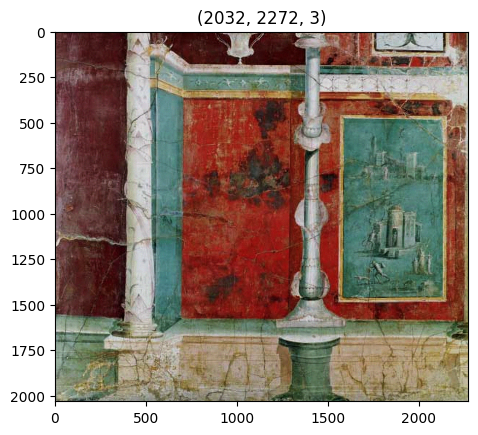

In [27]:
# Plot the HR image
hr_image = srmodel(image_plot)
plt.title(hr_image.shape)
plt.imshow(hr_image)
plt.show()

# Gray Scale Approach

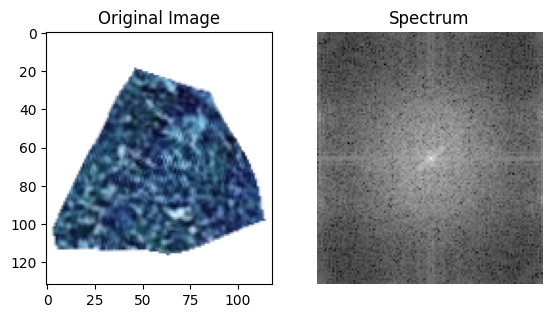

In [32]:
# convert image to grayscale
gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY) 
# compute the DFT of the gray scale image
gray_image_spectrum = calculate_dft2(gray_image)
# plot the original image and the current fourier spectrum 
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.subplot(1, 2, 2)
plot_2d_ft_spectrum(gray_image_spectrum, title='Spectrum')
plt.show()

### Applying Low Pass Filter

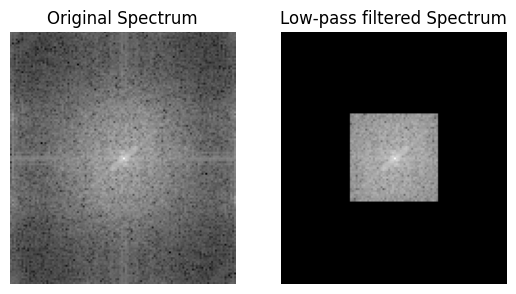

In [33]:
low_pass_gray_spectrum = apply_2d_low_pass_filter(gray_image_spectrum)

plt.subplot(1, 2, 1)
plot_2d_ft_spectrum(gray_image_spectrum, title='Original Spectrum', show=False)
plt.subplot(1, 2, 2)
plot_2d_ft_spectrum(low_pass_gray_spectrum, title='Low-pass filtered Spectrum', show=False)
plt.show()

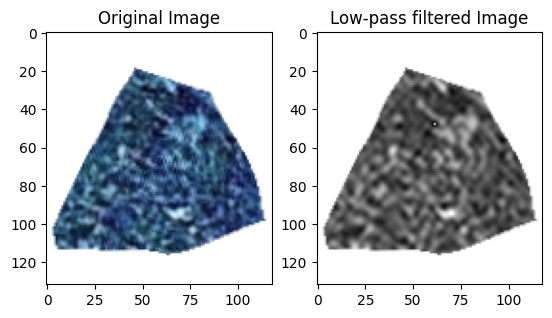

In [34]:
low_pass_gray_image = calculate_idft2(low_pass_gray_spectrum)
# simulate grayscale to RGB conversion by repeating the gray information and concatenating the alpha channel 
low_pass_gray_image = np.dstack((low_pass_gray_image, low_pass_gray_image, low_pass_gray_image, a)).astype(np.uint8)

plt.set_cmap(cmap='gray')
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(low_pass_gray_image)
plt.title('Low-pass filtered Image')
plt.show()

### Applying High Pass Filter

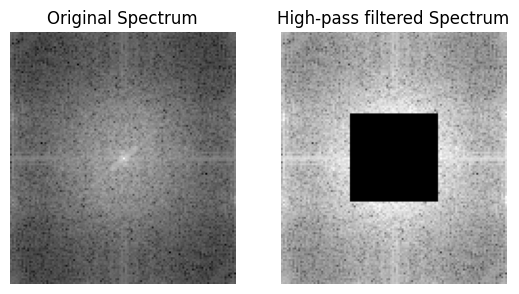

In [35]:
high_pass_gray_spectrum = apply_2d_high_pass_filter(gray_image_spectrum)

plt.subplot(1, 2, 1)
plot_2d_ft_spectrum(gray_image_spectrum, title='Original Spectrum', show=False)
plt.subplot(1, 2, 2)
plot_2d_ft_spectrum(high_pass_gray_spectrum, title='High-pass filtered Spectrum', show=False)
plt.show()

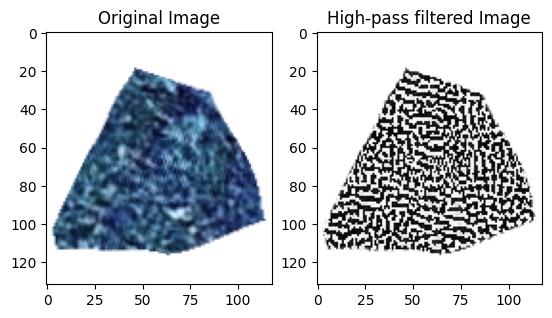

In [36]:
high_pass_gray_image = calculate_idft2(high_pass_gray_spectrum)
# simulate grayscale to RGB conversion by repeating the gray information and concatenating the alpha channel 
high_pass_gray_image = np.dstack((high_pass_gray_image, high_pass_gray_image, high_pass_gray_image, a)).astype(np.uint8)

plt.set_cmap(cmap='gray')
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(high_pass_gray_image)
plt.title('High-pass filtered Image')
plt.show()

### Applying Band Pass Filter

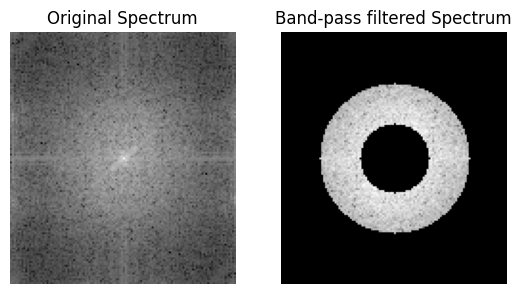

In [37]:
band_pass_gray_spectrum = apply_2d_band_pass_filter(gray_image_spectrum)

plt.subplot(1, 2, 1)
plot_2d_ft_spectrum(gray_image_spectrum, title='Original Spectrum', show=False)
plt.subplot(1, 2, 2)
plot_2d_ft_spectrum(band_pass_gray_spectrum, title='Band-pass filtered Spectrum', show=False)
plt.show()

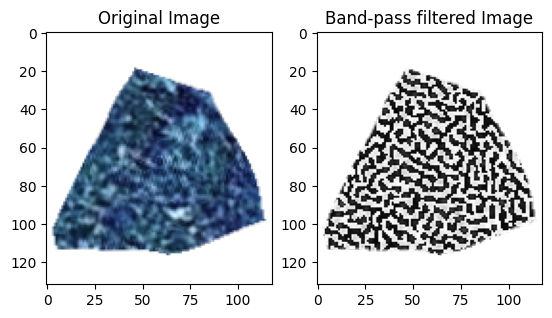

In [38]:
band_pass_gray_image = calculate_idft2(band_pass_gray_spectrum)
# simulate grayscale to RGB conversion by repeating the gray information and concatenating the alpha channel 
band_pass_gray_image = np.dstack((band_pass_gray_image, band_pass_gray_image, band_pass_gray_image, a)).astype(np.uint8)

plt.set_cmap(cmap='gray')
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(band_pass_gray_image)
plt.title('Band-pass filtered Image')
plt.show()

### Low-pass vs High-pass vs Band-pass

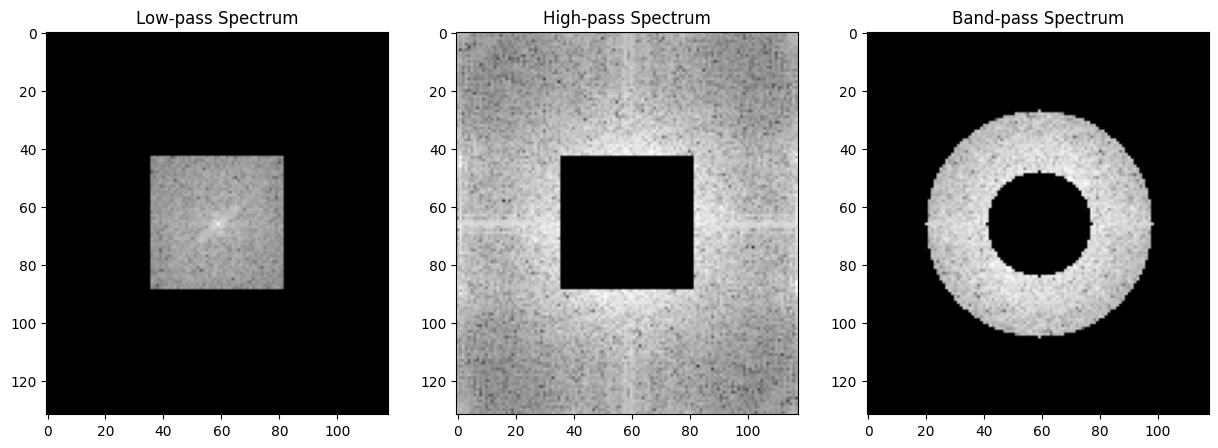

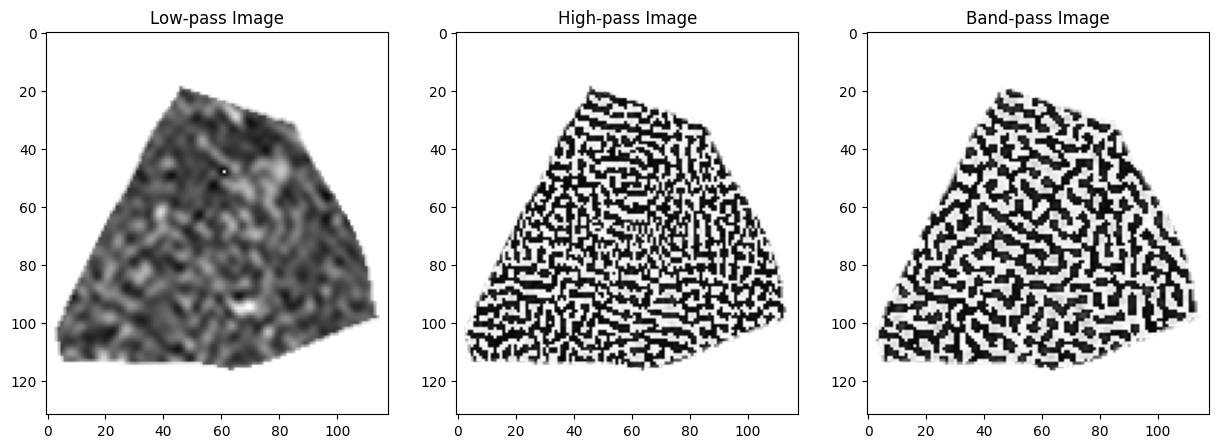

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
spectra = [low_pass_gray_spectrum, high_pass_gray_spectrum, band_pass_gray_spectrum]
titles = ["Low-pass Spectrum", "High-pass Spectrum", "Band-pass Spectrum"]

for i, ax in enumerate(axes):
    ax.imshow(20 * np.log(np.abs(spectra[i]) + 1))
    ax.set_title(titles[i])

plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
images = [low_pass_gray_image, high_pass_gray_image, band_pass_gray_image]
titles = ["Low-pass Image", "High-pass Image", "Band-pass Image"]

for i, ax in enumerate(axes):
    ax.imshow(images[i])  # Adjust the colormap if images are not grayscale
    ax.set_title(titles[i])
    
plt.show()

## RGB Splitting Approach

In [50]:
blue_spectrum = calculate_dft2(b)

green_spectrum = calculate_dft2(g)

red_spectrum = calculate_dft2(r)

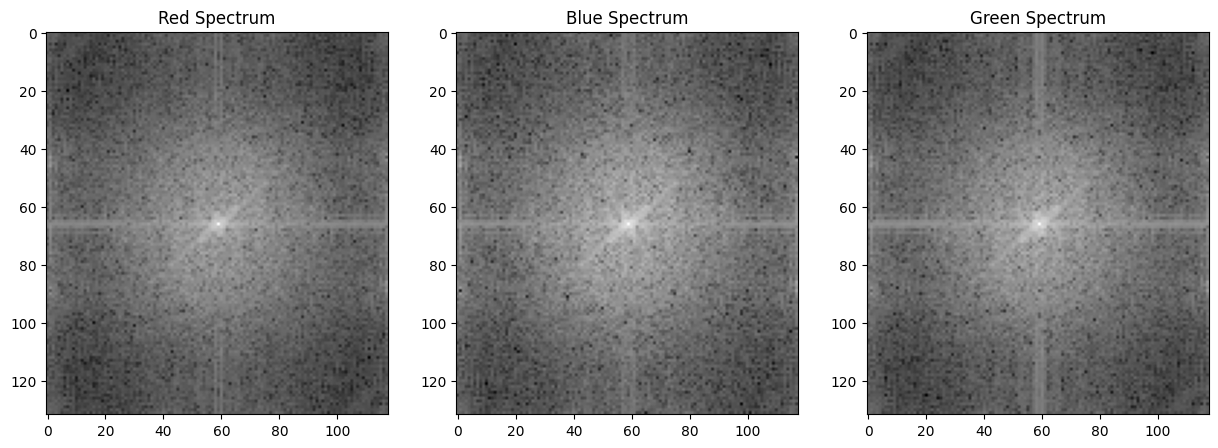

In [51]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
spectra = [red_spectrum, blue_spectrum, green_spectrum]
titles = ["Red Spectrum", "Blue Spectrum", "Green Spectrum"]

for i, ax in enumerate(axes):
    ax.imshow(20 * np.log(np.abs(spectra[i]) + 1))
    ax.set_title(titles[i])

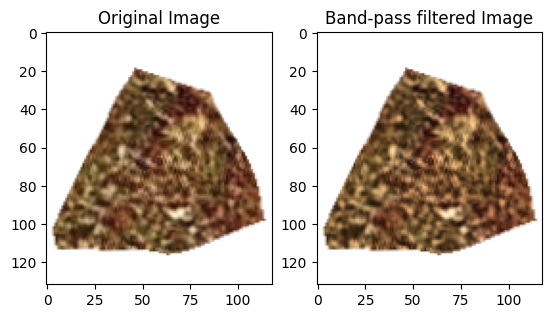

In [83]:
denoised_image = cv.fastNlMeansDenoisingColored(cv.cvtColor(image, cv.COLOR_BGR2RGB))

plt.set_cmap(cmap='gray')
plt.subplot(1, 2, 1)
plt.imshow(cv.merge((cv.cvtColor(image, cv.COLOR_BGR2RGB), a)))
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(cv.merge((denoised_image, a)))
plt.title('Band-pass filtered Image')
plt.show()

In [74]:
denoised_image.shape

(132, 118, 4)

### Applying Low Pass Filter

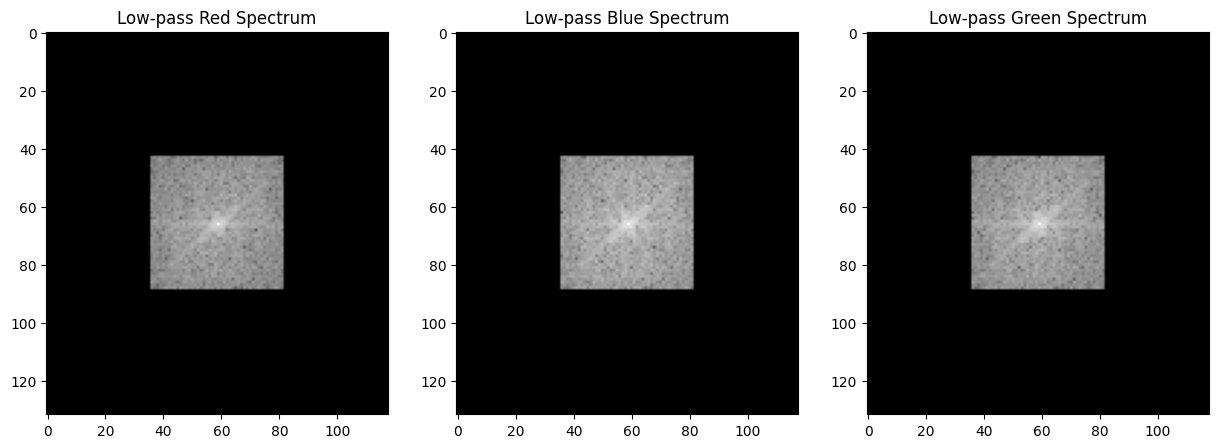

In [68]:
low_pass_blue_spectrum = apply_2d_low_pass_filter(blue_spectrum)

low_pass_green_spectrum = apply_2d_low_pass_filter(green_spectrum)

low_pass_red_spectrum = apply_2d_low_pass_filter(red_spectrum)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
spectra = [low_pass_red_spectrum, low_pass_blue_spectrum, low_pass_green_spectrum]
titles = ["Low-pass Red Spectrum", "Low-pass Blue Spectrum", "Low-pass Green Spectrum"]

for i, ax in enumerate(axes):
    ax.imshow(20 * np.log(np.abs(spectra[i]) + 1))
    ax.set_title(titles[i])

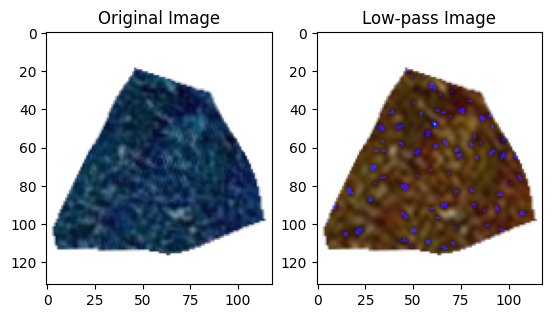

In [69]:
low_pass_blue_image = calculate_idft2(low_pass_blue_spectrum).astype(np.uint8)
low_pass_green_image = calculate_idft2(low_pass_green_spectrum).astype(np.uint8)
low_pass_red_image = calculate_idft2(low_pass_red_spectrum).astype(np.uint8)

low_pass_image = cv.merge((low_pass_red_image, low_pass_green_image, low_pass_blue_image, a)).astype(np.uint8)

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(low_pass_image)
plt.title('Low-pass Image')
plt.show()

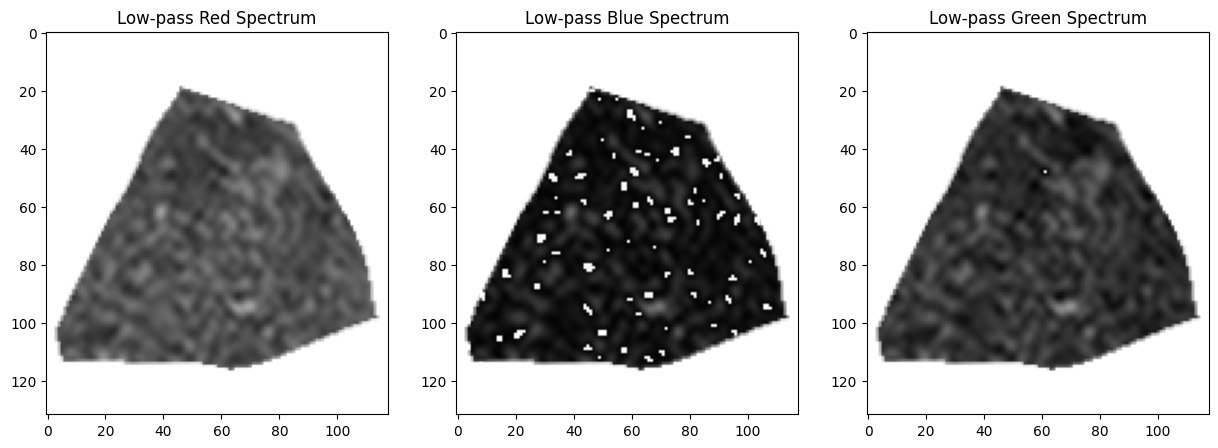

In [65]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
spectra = [cv.merge((low_pass_red_image, low_pass_red_image, low_pass_red_image, a)), cv.merge((low_pass_blue_image, low_pass_blue_image, low_pass_blue_image, a)), cv.merge((low_pass_green_image, low_pass_green_image, low_pass_green_image, a))]
titles = ["Low-pass Red Spectrum", "Low-pass Blue Spectrum", "Low-pass Green Spectrum"]

for i, ax in enumerate(axes):
    ax.imshow(spectra[i])
    ax.set_title(titles[i])

### Applying High Pass Filter

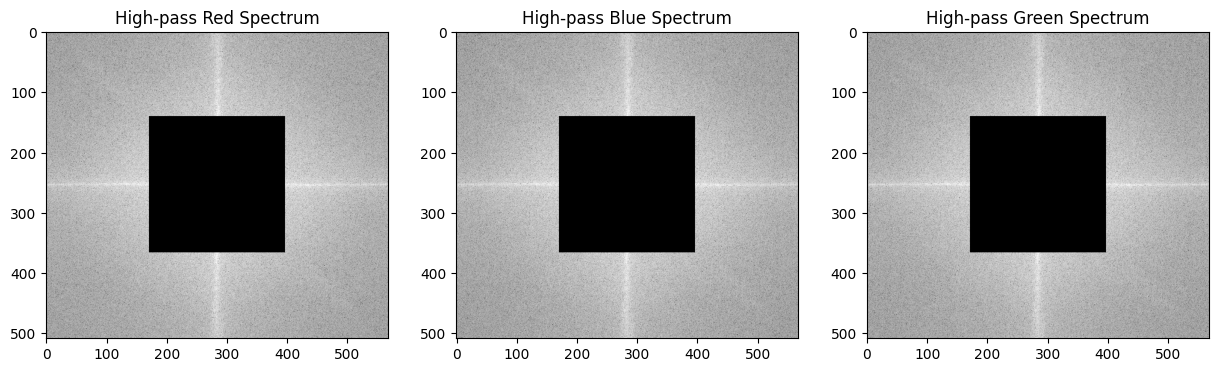

In [53]:
high_pass_blue_spectrum = apply_2d_high_pass_filter(blue_spectrum)

high_pass_green_spectrum = apply_2d_high_pass_filter(green_spectrum)

high_pass_red_spectrum = apply_2d_high_pass_filter(red_spectrum)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
spectra = [high_pass_red_spectrum, high_pass_blue_spectrum, high_pass_green_spectrum]
titles = ["High-pass Red Spectrum", "High-pass Blue Spectrum", "High-pass Green Spectrum"]

plt.set_cmap(cmap='gray')

for i, ax in enumerate(axes):
    ax.imshow(20 * np.log(np.abs(spectra[i]) + 1))
    ax.set_title(titles[i])

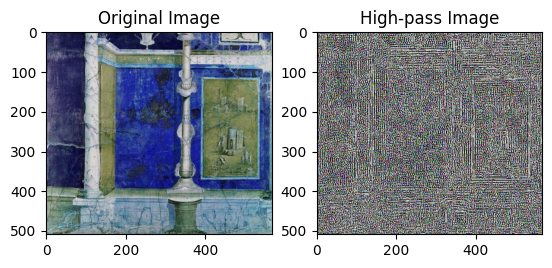

In [54]:
high_pass_blue_image = calculate_idft2(high_pass_blue_spectrum).astype(np.uint8)
high_pass_green_image = calculate_idft2(high_pass_green_spectrum).astype(np.uint8)
high_pass_red_image = calculate_idft2(high_pass_red_spectrum).astype(np.uint8)

high_pass_image = cv.merge((high_pass_blue_image, high_pass_green_image, high_pass_red_image, a)).astype(np.uint8)

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(high_pass_image)
plt.title('High-pass Image')
plt.show()

### Applying Band Pass Filter

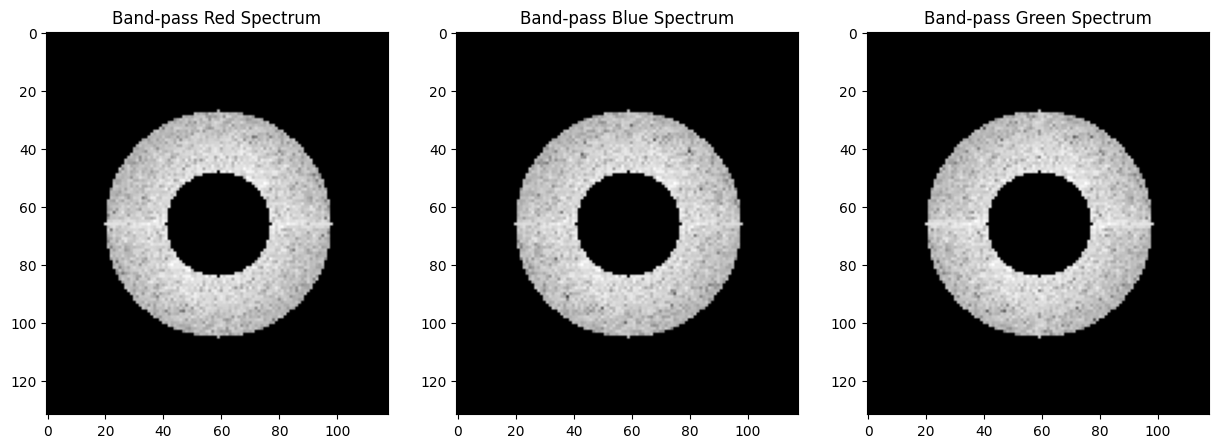

In [66]:
band_pass_blue_spectrum = apply_2d_band_pass_filter(blue_spectrum)

band_pass_green_spectrum = apply_2d_band_pass_filter(green_spectrum)

band_pass_red_spectrum = apply_2d_band_pass_filter(red_spectrum)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
spectra = [band_pass_red_spectrum, band_pass_blue_spectrum, band_pass_green_spectrum]
titles = ["Band-pass Red Spectrum", "Band-pass Blue Spectrum", "Band-pass Green Spectrum"]

plt.set_cmap(cmap='gray')

for i, ax in enumerate(axes):
    ax.imshow(20 * np.log(np.abs(spectra[i]) + 1))
    ax.set_title(titles[i])

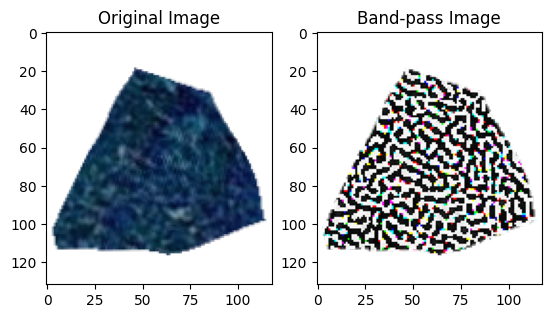

In [67]:
band_pass_blue_image = calculate_idft2(band_pass_blue_spectrum).astype(np.uint8)
band_pass_green_image = calculate_idft2(band_pass_green_spectrum).astype(np.uint8)
band_pass_red_image = calculate_idft2(band_pass_red_spectrum).astype(np.uint8)

band_pass_image = cv.merge((band_pass_blue_image, band_pass_green_image, band_pass_red_image, a)).astype(np.uint8)

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(band_pass_image)
plt.title('Band-pass Image')
plt.show()

## Edge Extraction 

We are currently interested only in the shape of the fragment and a variable region near the edges. In order to extract those, we leverage the alpha channel: if a pixel $x$ has an immediate neighbour pixel $x_{neigh}$ that has the alpha channel set to $0$, then $x$ is an edge pixel. 

From this point on, we extract a working region by considering pixels that are in a certain threshold from the contour. 

In [57]:
def old_alpha_edge_detector(input_img: np.ndarray) -> np.ndarray:
    """
    Detects edge pixels based on the alpha channel of an image.

    Args:
    - input_img (np.ndarray): Input image as a 3D numpy array (height x width x channels),
                              where channels include RGB and alpha.

    Returns:
    - edges (np.ndarray): Binary mask indicating edge pixels (1 for edge pixels, 0 otherwise),
                          same shape as input_img.

    Raises:
    - ValueError: If input_img does not have an alpha channel or is not a 3D array.

    The function iterates through each pixel in the input image and identifies edge pixels
    based on the alpha channel. A pixel is considered an edge pixel if its alpha value is non-zero
    and at least one of its neighboring pixels has an alpha value of zero.
    """

    if len(input_img.shape) != 3 or input_img.shape[2] < 4:
        raise ValueError("Input image must have an alpha channel.")

    rows, cols, _ = input_img.shape
    edges = np.zeros((rows, cols), dtype=np.uint8)

    # Create an array to store the offsets for neighboring pixels
    neighbor_offsets = np.array([[1, 0], [-1, 0], [0, 1], [0, -1]])

    for x in range(rows):
        for y in range(cols):
            # Skip if alpha is zero
            if input_img[x][y][3] == 0:
                continue

            # Iterate over neighboring pixels
            for offset_x, offset_y in neighbor_offsets:
                neighbor_x = x + offset_x
                neighbor_y = y + offset_y

                # Check if neighbor is out of bounds or has alpha zero
                if (not (0 <= neighbor_x < rows and 0 <= neighbor_y < cols)
                        or input_img[neighbor_x][neighbor_y][3] == 0):
                    edges[x][y] = 1
                    break
    return edges


def old_extract_working_region(input_img: np.ndarray, threshold: int = 5) -> np.ndarray:
    """
    Extracts the interpolation region around edge pixels in an image.

    Args:
    - input_img (np.ndarray): Input image as a 3D numpy array (height x width x channels),
                              where channels include RGB and alpha.
    - threshold (int): Threshold distance from edge pixels. Defaults to 5.

    Returns:
    - interpolation_region (np.ndarray): Interpolation region around edge pixels,
                                         same shape as input_img.

    Raises:
    - ValueError: If input_img does not have an alpha channel or is not a 3D array.

    The function iterates through each pixel in the input image and identifies edge pixels
    based on the alpha channel. It then extracts pixels within a specified distance from the edge
    (defined by the threshold) to form the interpolation region.
    """

    if len(input_img.shape) != 3 or input_img.shape[2] < 4:
        raise ValueError("Input image must have an alpha channel.")

    rows, cols, _ = input_img.shape
    interpolation_region = np.zeros_like(input_img)

    neighbor_offsets = np.array([[1, 0], [-1, 0], [0, 1], [0, -1]])

    for x in range(rows):
        for y in range(cols):
            for offset_x, offset_y in neighbor_offsets:
                neighbor_x = x + offset_x
                neighbor_y = y + offset_y

                # Check if neighbor is out of bounds or has alpha zero and move in the opposite direction
                if (not (0 <= neighbor_x < rows and 0 <= neighbor_y < cols)
                        or input_img[neighbor_x][neighbor_y][3] == 0):

                    # Add all the valid pixel in [1, threshold] to the interpolation region
                    for t in range(1, threshold + 1):
                        if offset_x > 0 or offset_y > 0:
                            opposite_x = neighbor_x - t if offset_x != 0 else neighbor_x
                            opposite_y = neighbor_y - t if offset_y != 0 else neighbor_y
                        else:
                            opposite_x = neighbor_x + t if offset_x != 0 else neighbor_x
                            opposite_y = neighbor_y + t if offset_y != 0 else neighbor_y

                        # Check if pixel is out of bounds
                        if not (0 <= opposite_x < rows and 0 <= opposite_y < cols):
                            break

                        # If inner pixel has content, add it to the interpolation region
                        if input_img[opposite_x][opposite_y][3] != 0:
                            interpolation_region[opposite_x][opposite_y] = input_img[opposite_x][opposite_y]

    return interpolation_region

In [58]:
def opt_extract_working_region(input_img: np.ndarray, threshold: int = 0) -> np.ndarray:
    """
    Extracts the working region around edge pixels in an image.

    Args:
    - input_img (np.ndarray): Input image as a 3D numpy array (height x width x channels),
                              where channels include RGB and alpha.
    - threshold (int): Threshold distance from edge pixels. If 0, it returns the shape of the fragment.                         Defaults to 0.

    Returns:
    - working_region (np.ndarray): Interpolation region around edge pixels,
                                         same shape as input_img.

    Raises:
    - ValueError: If input_img does not have an alpha channel or is not a 3D array.

    The function iterates through each pixel in the input image and identifies edge pixels
    based on the alpha channel. It then extracts pixels within a specified distance from the edge
    (defined by the threshold) to form the working region.
    """

    assert len(input_img.shape) == 3 and input_img.shape[2] >= 4

    working_region = np.zeros_like(input_img)

    # Define the neighbor offsets for 4-connectivity
    neighbor_offsets = np.array([[1, 0], [-1, 0], [0, 1], [0, -1]])
    # Pad the input image with zeros to handle boundary conditions
    padded_img = np.pad(input_img, ((1, 1), (1, 1), (0, 0)), mode='constant')

    for offset_x, offset_y in neighbor_offsets:
        # Shift the image array to obtain the neighbor pixels
        neighbor_x = np.roll(padded_img, offset_x, axis=0)
        neighbor_y = np.roll(padded_img, offset_y, axis=1)

        # Create a mask to identify pixels with alpha zero in the neighbors
        edge_mask = (neighbor_x[1:-1, 1:-1, 3] == 0) | (neighbor_y[1:-1, 1:-1, 3] == 0)
        
        working_region[edge_mask] = input_img[edge_mask]

        if threshold > 0:
            working_mask = edge_mask.copy()
            # Expand the mask to include pixels within the threshold distance
            for t in range(1, threshold + 1):
                opposite_x = np.roll(edge_mask, -t * offset_x, axis=0)
                opposite_y = np.roll(edge_mask, -t * offset_y, axis=1)
    
                working_mask = working_mask | (opposite_x | opposite_y)
            working_region[working_mask] = input_img[working_mask]
            

    return working_region



CPU times: user 5.62 s, sys: 22.1 ms, total: 5.64 s
Wall time: 5.66 s


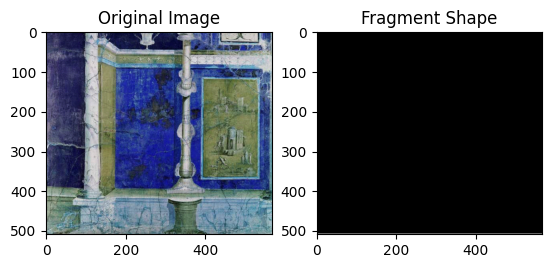

In [59]:
%time fragment_shape = old_alpha_edge_detector(image)

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(fragment_shape)
plt.title('Fragment Shape')
plt.show()

CPU times: user 27.8 ms, sys: 4.85 ms, total: 32.7 ms
Wall time: 32 ms


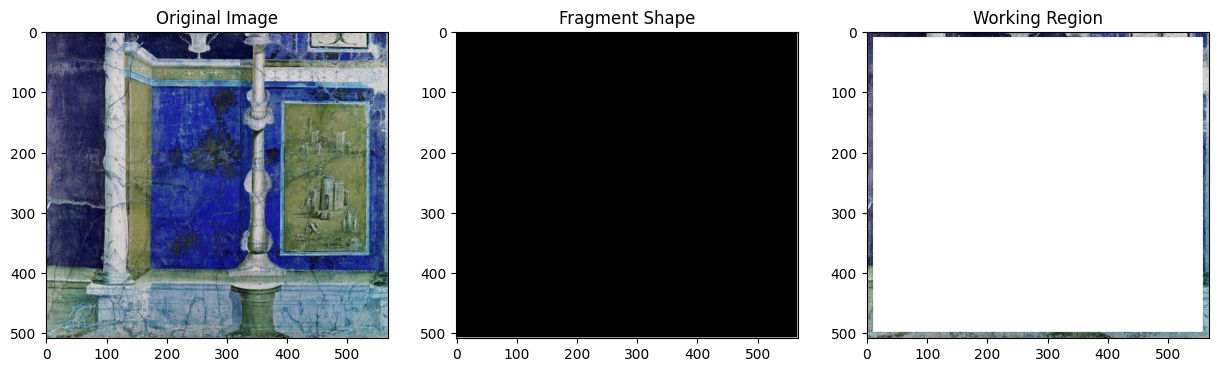

In [60]:
# extracting the working region 
%time working_region = extract_working_region(image, threshold=10)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
images = [image, fragment_shape, working_region]
titles = ["Original Image", "Fragment Shape", "Working Region"]

for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.set_title(titles[i])

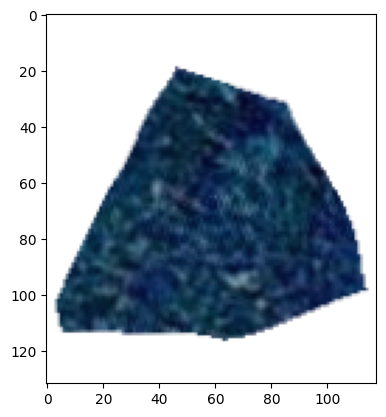

CPU times: user 178 ms, sys: 2.85 ms, total: 181 ms
Wall time: 181 ms
CPU times: user 3.23 ms, sys: 117 µs, total: 3.35 ms
Wall time: 3.34 ms


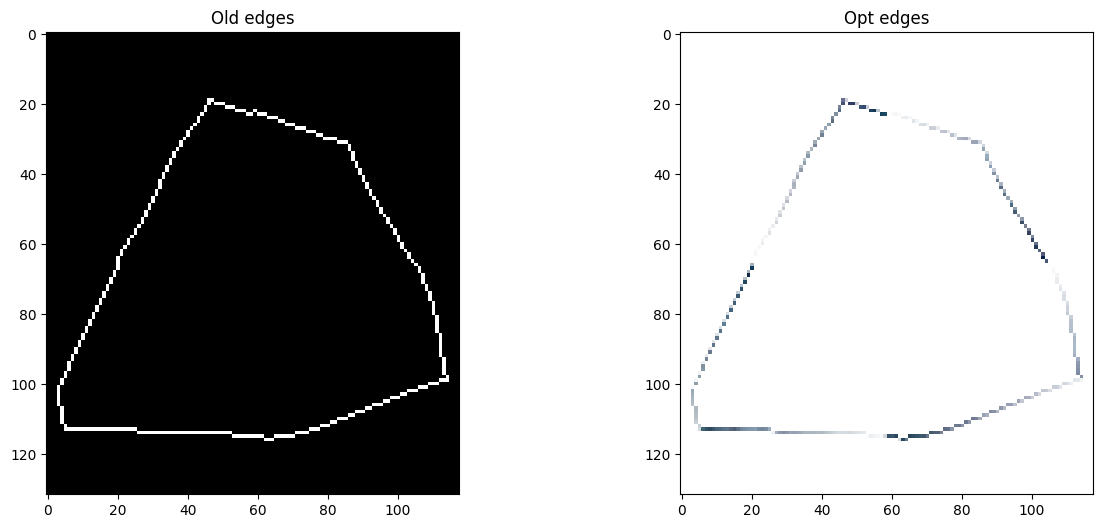

In [61]:
image = cv.imread("data/5.2.16.png", cv.IMREAD_UNCHANGED)

plt.imshow(image)
plt.show()

%time old_edges = old_alpha_edge_detector(image)
%time opt_edges = opt_extract_working_region(image)

plt.figure(figsize=(15, 6))
plt.subplot(1,2 ,1)
plt.imshow(old_edges)
plt.title("Old edges")
plt.subplot(1,2 ,2)
plt.imshow(opt_edges)
plt.title("Opt edges")
plt.show()

CPU times: user 831 ms, sys: 25.1 ms, total: 856 ms
Wall time: 847 ms
CPU times: user 6.84 ms, sys: 522 µs, total: 7.36 ms
Wall time: 7.35 ms


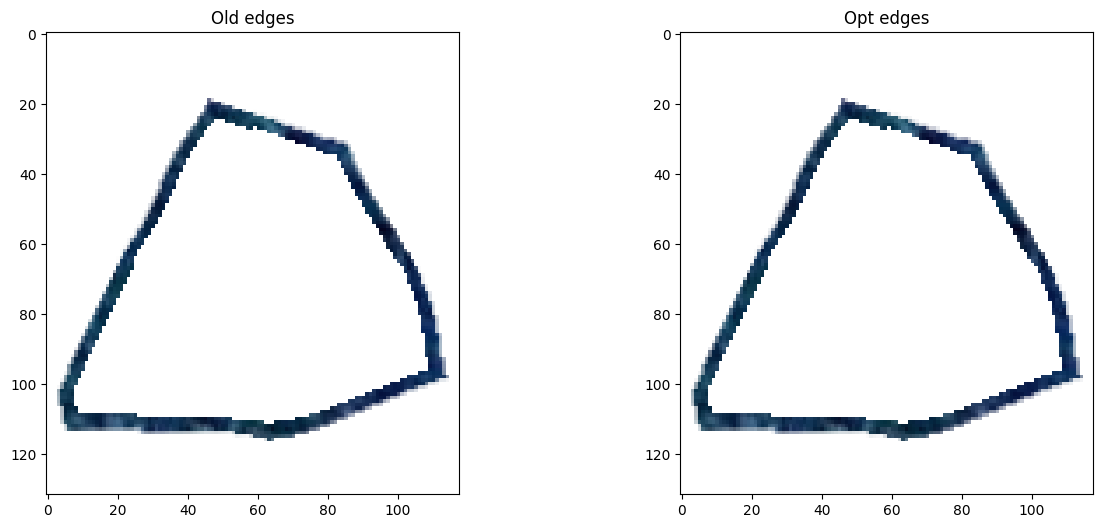

In [62]:
%time old_region = old_extract_working_region(image)
%time opt_region = opt_extract_working_region(image, threshold=5)

plt.figure(figsize=(15, 6))
plt.subplot(1,2 ,1)
plt.imshow(old_region)
plt.title("Old edges")
plt.subplot(1,2 ,2)
plt.imshow(opt_region)
plt.title("Opt edges")
plt.show()